[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1Vkbwawh2LXn3Nv4bp38VNzwrAmPYTKGo#scrollTo=PN0mloarZ0Ye)

**`Image Captioning using Tensorflow and Keras`**

**The following code was implemented in Google Colab so make sure to set up your colab and mount your drive to give proper path to your dataset**

Mounting the drive to access data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing the needed libraries

In [ ]:
# importing necessary libraries
import os
import glob
import string
import numpy as np
import pandas as pd
import pickle
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3
from tqdm import tqdm
import tensorflow.keras.preprocessing.image
from PIL import Image

In [ ]:
START = "startseq"
END = "endseq"
USE_INCEPTION = True

In [ ]:
 root_dir = '/content/drive/MyDrive/Colab Files/Image Captioning'

Next we will create a funtion to clean the captions

In [ ]:
def clean_description(description):
    translator = str.maketrans('', '', string.punctuation)

    # Cleaning the description
    desc = [word.lower() for word in description] #To convert all the word to lower case
    desc = [w.translate(translator) for w in desc] #To remove all the punctuations from the descriptions
    desc = [word for word in desc if len(word) > 1] #To remove all the word whose length is <= 1
    desc = [word for word in desc if word.isalpha()] #Removing all the non alphabetic characters

    return ' '.join(desc)

def read_token_file(file_path):
    lookup = dict()

    with open(file_path, 'r') as text:
        max_length = 0
        for line in text.read().split('\n'):
            tokens = line.split()
            if len(tokens) >= 2:
                image_id = tokens[0].split('.')[0]
                description = tokens[1:]

                cleaned_desc = clean_description(description)

                max_length = max(max_length, len(cleaned_desc.split()))

                if image_id not in lookup:
                    lookup[image_id] = list()
                lookup[image_id].append(cleaned_desc)

    return lookup, max_length

def create_dictionary(lookup):
    dictionary = set()
    for key in lookup:
        [dictionary.update(desc.split()) for desc in lookup[key]]

    return dictionary

token_file_path = os.path.join(root_dir, 'Flickr8k.token.txt')
lookup, max_length = read_token_file(token_file_path)


# #Creating the dictionary of words
dictionary = create_dictionary(image_descriptions)

In [ ]:
print(max_length) #Maximum length of the description
print(len(lookup)) #Total number of images
print(len(dictionary)) #Total uniques words on in other sense our dictionary

32
8092
8763


Working with the images

In [ ]:
img = glob.glob(os.path.join(root_dir,'Flicker8k_Dataset', '*.jpg'))

In [ ]:
len(img)

8091

In [ ]:
# Next step is to find out whether the image in img belongs to train images dataset or the test image dataset
#We will then append the image in their respective folder for further training



def read_image_list(file_path):
    with open(file_path, 'r') as file:
        return set(file.read().strip().split('\n'))


train_images_path = os.path.join(root_dir, 'Flickr_8k.trainImages.txt')
test_images_path = os.path.join(root_dir, 'Flickr_8k.testImages.txt')

train_images_set = read_image_list(train_images_path)
test_images_set = read_image_list(test_images_path)

def classify_images(images_list):
    train_images_list = []
    test_images_list = []

    for img_path in images_list:
        img_id = os.path.split(img_path)[-1] #This splits the path at '/' and we get the last token which is the image id

        if img_id in train_images_set:
            train_images_list.append(img_id)
        elif img_id in test_images_set:
            test_images_list.append(img_id)

    return train_images_list, test_images_list

train_img, test_img = classify_images(img)

In [ ]:
#Size of our training image dataset
print(len(train_img))
#Size of our testing image dataset
print(len(test_img))

6000
1000


In [ ]:
train_descriptions = {k:v for k,v in lookup.items() if f'{k}.jpg' in train_images}

#The next step id to append the 'startseq' at the beginning and 'endseq' at the end of every descriptions.
#You will see in the future why this is essential
for n,v in train_descriptions.items():
    for d in range(len(v)):
        v[d] = f'{START} {v[d]} {END}'

In [ ]:
len(train_descriptions)

6000

In [ ]:
#Important import for model training
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation
from tensorflow.keras.layers import Flatten, Reshape, concatenate, Dropout, BatchNormalization, add
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


### Working with the CNN Model
We will be working with [InceptionV3](https://keras.io/api/applications/inceptionv3/) model as our main CNN model.

There are many transfer learning models available to use. You can also use [VGG16 / VGG19](https://keras.io/api/applications/vgg/) and [MobileNets](https://arxiv.org/abs/1704.04861)

In [ ]:
'''
Now we will be using InceptionV3(which is trained on ImageNet dataset) to extract features from
images. And similarly will be using GloVe to extract features from raw text or in our case the
captions
'''
encode_model = InceptionV3(weights='imagenet')
encode_model = Model(encode_model.input, encode_model.layers[-2].output)
#The standarad input for InceptionV3 is 299 x 299
WIDTH = 299
HEIGHT = 299
OUTPUT_DIM = 2048
preprocess_input = tensorflow.keras.applications.inception_v3.preprocess_input

96124928/96112376 [==============================] - 1s 0us/step


In [ ]:
encode_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

The next few step will be very crucial as we will be encoding our images for final training of the model. The encoding will take a considerable amount of time given the dataset. So it would be benificial to save it in the form of pickle file for later use.






Changing my root directory for proper storing and loading of files

In [ ]:
%cd /content/drive/My Drive/Colab Files/Image Captioning/

/content/drive/My Drive/Colab Files/Image Captioning


Next few step we will be encoding our images using InceptionV3 to extract features.

In [ ]:
def encode_image(img):
    # Resize all images to a standard size
    resized_img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)

    # Convert a PIL image to a numpy array
    img_array = tensorflow.keras.preprocessing.image.img_to_array(resized_img)

    # Expand to 2D array
    img_array = np.expand_dims(img_array, axis=0)

    # Perform any preprocessing needed by the image encoding model (e.g., InceptionV3)
    img_array = preprocess_input(img_array)

    # Call the image encoding model (e.g., InceptionV3) to extract the feature vector for the image
    encoding_vector = encode_model.predict(img_array)

    # Reshape to the correct form to be accepted by the LSTM captioning network
    encoding_vector = np.reshape(encoding_vector, OUTPUT_DIM)

    return encoding_vector


In [ ]:
def generate_image_encodings(image_list, root_directory):
    encodings = {}

    for image_id in tqdm(image_list):
        image_path = os.path.join(root_directory, 'Flicker8k_Dataset', image_id)
        image = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
        encodings[image_id] = encode_image(image)

    return encodings

encoding_train = generate_image_encodings(train_img, root_dir)


In [ ]:
with open('train', "wb") as file:
      pickle.dump(encodings, file)



In [ ]:
def generate_test_image_encodings(image_list, root_directory):
    encodings = {}

    for image_id in tqdm(image_list):
        image_path = os.path.join(root_directory, 'Flicker8k_Dataset', image_id)
        image = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
        encodings[image_id] = encode_image(image)

    return encodings

encoding_test = generate_test_image_encodings(test_img, root_dir)


100%|██████████| 1000/1000 [08:37<00:00,  1.93it/s]


In [ ]:
with open('test', "wb") as file:
    pickle.dump(encoding_test, file)

Loading the train and test features with pickle.load

In [ ]:
with open('train',"rb") as file:
    encoding_train = pickle.load(file)

In [ ]:
with open('test',"rb") as file:
    encoding_test = pickle.load(file)

Next step is to find out how many captions will be used in training.

In [ ]:
def collect_all_captions(descriptions):
    all_captions = []
    for key, captions in descriptions.items():
        for caption in captions:
            all_captions.append(caption)
    return all_captions

all_training_captions = collect_all_captions(train_descriptions)
print(len(all_training_captions))


30000


In [ ]:
def filter_words_by_threshold(captions, threshold):
    word_counts = {}

    # Count the occurrences of each word in the captions
    for sentence in captions:
        for word in sentence.split(' '):
            word_counts[word] = word_counts.get(word, 0) + 1

    # Filter words based on the given threshold
    filtered_vocab = [word for word in word_counts if word_counts[word] >= threshold]

    return filtered_vocab , word_counts


word_count_threshold = 10
vocab , word_counts = filter_words_by_threshold(all_training_captions, word_count_threshold)
print('Vocabulary reduced from %d to %d.' % (len(word_counts), len(vocab)))

Vocabulary reduced from 7578 to 1651.


Creating a word to index and index to word. You can also perfrom this using Spacy

In [ ]:
def create_word_index_mapping(vocabulary):
    word_to_index = {}
    index_to_word = {}

    index = 1
    for word in vocabulary:
        word_to_index[word] = index
        index_to_word[index] = word
        index += 1

    return word_to_index, index_to_word


wordtoidx , idxtoword = create_word_index_mapping(vocab)
vocab_size = len(idxtoword) + 1  # 1 is added for padding
print(vocab_size)


1652

Previously we found out that maximum length of the sentence is 32. But later we added startseq at the beginning and endseq at the end. This increases our max_length to 32+2.

In [ ]:
max_length = max_length + 2

In [ ]:
max_length

34

## Using Data Generator
Previously we have used ImageDataGenerator during CNN training. Here we will do the same. We will be using Data Generator to generate training data as the Neural Network needs it.

Data generate will yield inputs as featrurs of image and a series of caption words(as the entire caption won't be directly given as input). The neural nets will generate the next word in the caption. Hence the next word will be stored in out_seq as shown in below cell

In [ ]:
def data_generator(captions_dict, image_features, word_to_index, max_caption_length, num_photos_per_batch):
    image_inputs, caption_inputs, caption_outputs = [], [], []
    batch_count = 0

    while True:
        for image_key, caption_list in captions_dict.items():
            batch_count += 1
            image_feature = image_features[image_key + '.jpg']

            for caption in caption_list:
                sequence = [word_to_index[word] for word in caption.split(' ') if word in word_to_index]

                for i in range(1, len(sequence)):
                    input_seq, output_seq = sequence[:i], sequence[i]
                    input_seq = pad_sequences([input_seq], maxlen=max_caption_length)[0]
                    output_seq = to_categorical([output_seq], num_classes=vocab_size)[0]

                    image_inputs.append(image_feature)
                    caption_inputs.append(input_seq)
                    caption_outputs.append(output_seq)

            if batch_count == num_photos_per_batch:
                yield ([np.array(image_inputs), np.array(caption_inputs)], np.array(caption_outputs))
                image_inputs, caption_inputs, caption_outputs = [], [], []
                batch_count = 0




The glove embedding has 200 dimensional vectors.

In [ ]:
def load_embedding_index(file_path):
    embedding_index = {}

    with open(file_path, encoding="utf-8") as file:
        for line in tqdm(file):
            values = line.split()
            word = values[0]
            vectors = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = vectors

    return embedding_index

embedding_index = load_embedding_index(os.path.join(root_dir, 'glove.6B.200d.txt'))


400000it [00:28, 13841.75it/s]


In [ ]:
len(embedding_index)

400000

### Building Neural Network

The embedding matrix created from Glove will be directly copied to weights matrix of neural network.

The below cell converts all the words in our vocabulary to their respective vector representaion using Glove embedding. If in any case, the word is not present in embedding_index, it will be embedded as 0.

In [ ]:
def create_embedding_matrix(word_to_index, embedding_index, embedding_dim):
    vocab_size = len(word_to_index) + 1  # 1 is added for padding
    matrix = np.zeros((vocab_size, embedding_dim))

    for word, index in word_to_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
             # Words not found in the embedding index will be all zeros
            matrix[index] = embedding_vector

    return matrix


embedding_dim = 200 #This embedding cannot be changed
embedding_matrix = create_embedding_matrix(wordtoidx, embedding_index, embedding_dim)


The shape of the embedding matrix created in the above cell will be (len(vocab_size),dimension). Let's confirm it.

In [ ]:
embedding_matrix.shape

(1652, 200)

## LSTM
The model will have 2 inputs.

Input 1 will be for out image features. The input shape for our first input in our model will be the output shape of our InceptionV3 model i.e. 2048(stored in OUTPUT_DIM).

Input 2 will be the captions. The input shape for this input will be the max_length = 34. (This will be LSTM).


In [ ]:
def create_caption_model(output_dim, max_caption_length, vocab_size, embedding_dim):
    # Input for features
    input_features = Input(shape=(output_dim,))
    dropout_features = Dropout(0.5)(input_features)
    dense_features = Dense(256, activation='relu')(dropout_features)

    # Input for captions
    input_captions = Input(shape=(max_caption_length,))
    embedded_captions = Embedding(vocab_size, embedding_dim, mask_zero=True)(input_captions)
    dropout_captions = Dropout(0.5)(embedded_captions)
    lstm_captions = LSTM(256)(dropout_captions)

    # Main decoder with inputs as features and captions
    merged_decoder = add([dense_features, lstm_captions])
    dense_decoder = Dense(256, activation='relu')(merged_decoder)

    # Output layer with softmax activation for classification
    output_layer = Dense(vocab_size, activation='softmax')(dense_decoder)

    # Build the model
    caption_model = Model(inputs=[input_features, input_captions], outputs=output_layer)

    return caption_model

caption_model = create_caption_model(OUTPUT_DIM, max_length, vocab_size, embedding_dim)


In [ ]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
caption_model.layers[2].set_weights([embedding_matrix]) #Setting the weights as our embedding matrix
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

###Let the training begin!!

In [ ]:
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath
EPOCHS = 10
for i in tqdm(range(EPOCHS*2)):
    generator = data_generator(train_descriptions, encoding_train,
                    wordtoidx, max_length, number_pics_per_bath)
    caption_model.fit_generator(generator, epochs=1,
                    steps_per_epoch=steps, verbose=1)


Training will take considerable amount of time even after using fast GPU of Colab, hence it will be better to save the weights of the model once the training is finished.

In [ ]:
caption_model.save_weights("fresh_model_wt.hdf5")

In [ ]:
caption_model.load_weights("fresh_model_wt.hdf5")

# Predicting New Catptions
When predicting new caption, it is important to note that inputs are given sequentially to LSTM. So rather than running for one time LSTM will run multiple times given the length of the caption to be generated.

For e.g., LSTM is given the features of the photo along with one single word ('startseq') as input. Then it generates another word and append it the main string. In the next step LSTM is given the features along with the newly generated string with the new word appended as input and it predicts the next. This process continues until the max_length is reached or 'endseq' is reached.

In [ ]:
def generateCaption(photo):
    in_text = START
    for i in range(max_length): #The maximum length of caption cannot exceed max_length = 34
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == END:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

/content/drive/MyDrive/Colab Files/Image Captioning/Flicker8k_Dataset/3767841911_6678052eb6.jpg


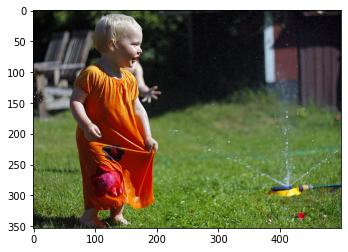

Caption: little girl in pink shirt is running through the grass
_____________________________________
/content/drive/MyDrive/Colab Files/Image Captioning/Flicker8k_Dataset/387830531_e89c192b92.jpg


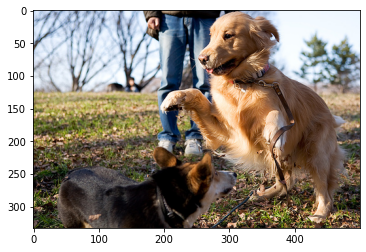

Caption: two dogs are running through the grass
_____________________________________
/content/drive/MyDrive/Colab Files/Image Captioning/Flicker8k_Dataset/384577800_fc325af410.jpg


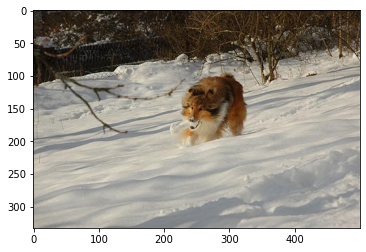

Caption: dog runs through the snow
_____________________________________
/content/drive/MyDrive/Colab Files/Image Captioning/Flicker8k_Dataset/391579205_c8373b5411.jpg


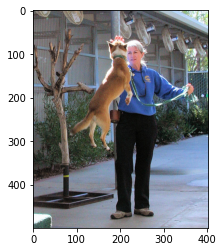

Caption: two children are playing with ball in the backyard
_____________________________________
/content/drive/MyDrive/Colab Files/Image Captioning/Flicker8k_Dataset/396360611_941e5849a3.jpg


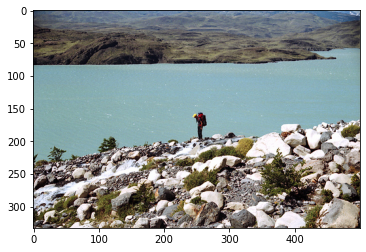

Caption: two people are standing on cliff overlooking the ocean
_____________________________________


In [ ]:
for z in range(5): # set higher to see more examples
    pic = list(encoding_test.keys())[z]
    image = encoding_test[pic].reshape((1,OUTPUT_DIM))
    print(os.path.join(root_dir,'Flicker8k_Dataset', pic))
    x=plt.imread(os.path.join(root_dir,'Flicker8k_Dataset', pic))
    plt.imshow(x)
    plt.show()
    print("Caption:",generateCaption(image))
    print("_____________________________________")

## THANK YOU